In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance


In [ ]:
# Set the style for all plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

In [ ]:
# Load data
data = pd.read_csv('/content/synthetic_crystal_structure_dataset.csv')

In [ ]:
#displaying basic information
print("Dataset Shape:", data.shape)
print("\nData Preview:")
print(data.head())
print("\nData Summary:")
print(data.describe())

Dataset Shape: (90, 5)

Data Preview:
   Alloy Crystal Structure  Grain Size (µm)  Alloy Composition (%)  \
0  Ni-Ag               FCC            41.09                  22.27   
1  Pb-Al               BCC            36.40                  17.91   
2  Ti-Au               HCP            27.59                   2.78   
3  Pb-Zn               HCP            25.11                  41.20   
4  Au-Cu               HCP            49.62                  51.19   

   Ductility (%)  
0          21.27  
1           1.12  
2          58.33  
3          11.84  
4          21.57  

Data Summary:
       Grain Size (µm)  Alloy Composition (%)  Ductility (%)
count        90.000000              90.000000      90.000000
mean         24.362333              42.695000      32.393667
std          14.364439              28.047797      18.290634
min           0.820000               0.130000       1.120000
25%          12.222500              20.297500      19.320000
50%          24.175000              41.585000 

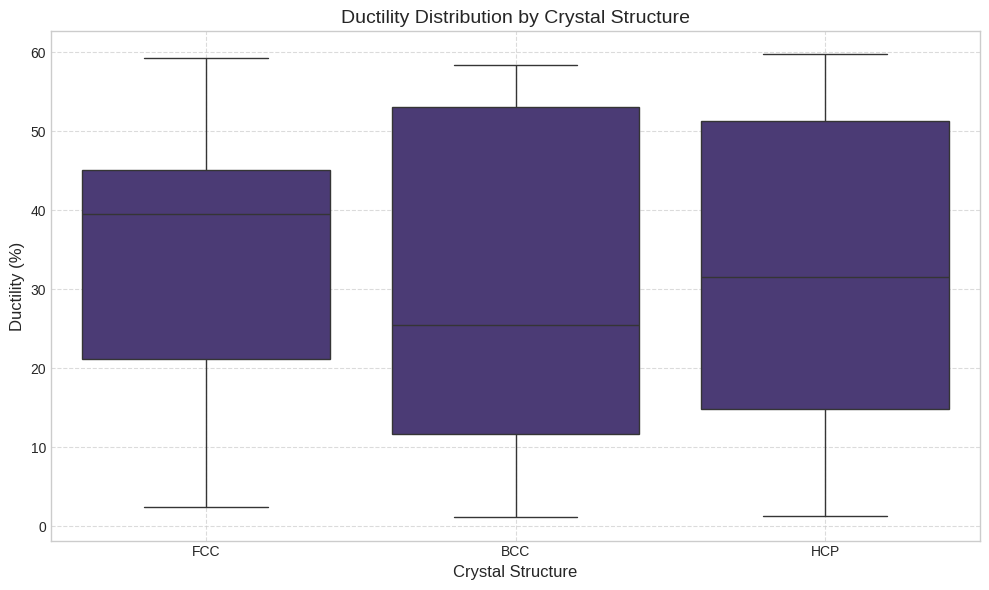

In [ ]:
# Analyze ductility by crystal structure
plt.figure(figsize=(10, 6))
sns.boxplot(x='Crystal Structure', y='Ductility (%)', data=data)
plt.title('Ductility Distribution by Crystal Structure', fontsize=14)
plt.xlabel('Crystal Structure', fontsize=12)
plt.ylabel('Ductility (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ductility_by_crystal_structure.png', dpi=300)
plt.show()


FEATURE ENGINEERING


In [7]:
# 1. One-hot encode crystal structure using pandas get_dummies (simpler approach)
crystal_dummy = pd.get_dummies(data['Crystal Structure'], prefix='Crystal', drop_first=False)
data = pd.concat([data, crystal_dummy], axis=1)

In [8]:
# 2. Create interaction terms between crystal structure and grain size
data['FCC_GrainSize'] = data['Crystal_FCC'] * data['Grain Size (µm)'] if 'Crystal_FCC' in data.columns else 0
data['BCC_GrainSize'] = data['Crystal_BCC'] * data['Grain Size (µm)'] if 'Crystal_BCC' in data.columns else 0
data['HCP_GrainSize'] = data['Crystal_HCP'] * data['Grain Size (µm)'] if 'Crystal_HCP' in data.columns else 0


In [9]:
# Simulate atomic radius ratio based on alloy composition
data['Atomic_Radius_Ratio'] = 0.8 + 0.4 * np.sin(data['Alloy Composition (%)'] / 10)


In [10]:
# Simulate electronegativity difference based on alloy composition
data['Electronegativity_Diff'] = 0.3 + 0.7 * np.cos(data['Alloy Composition (%)'] / 20)

# Simulate temperature effect (room temperature testing vs elevated)
np.random.seed(42)
data['Temperature_Effect'] = np.random.normal(1.0, 0.2, size=len(data))


In [11]:
# Simulate strain rate sensitivity
data['Strain_Rate_Sensitivity'] = 0.1 + 0.1 * np.random.random(size=len(data))


In [13]:
# Check for the correct column names
print("\nAvailable columns after feature engineering:")
print(data.columns.tolist())


Available columns after feature engineering:
['Alloy', 'Crystal Structure', 'Grain Size (µm)', 'Alloy Composition (%)', 'Ductility (%)', 'Crystal_BCC', 'Crystal_FCC', 'Crystal_HCP', 'FCC_GrainSize', 'BCC_GrainSize', 'HCP_GrainSize', 'Atomic_Radius_Ratio', 'Electronegativity_Diff', 'Temperature_Effect', 'Strain_Rate_Sensitivity']


In [14]:
# Prepare features and target based on actual column names
crystal_columns = [col for col in data.columns if col.startswith('Crystal_')]
interaction_columns = [col for col in data.columns if col.endswith('_GrainSize') and col in data.columns]

feature_columns = [
    'Grain Size (µm)', 'Alloy Composition (%)'
] + crystal_columns + interaction_columns + [
    'Atomic_Radius_Ratio', 'Electronegativity_Diff',
    'Temperature_Effect', 'Strain_Rate_Sensitivity'
]

In [15]:
#Verify that all feature columns exist
existing_columns = [col for col in feature_columns if col in data.columns]
print("\nUsing these features:")
print(existing_columns)

X = data[existing_columns]
y = data['Ductility (%)']



Using these features:
['Grain Size (µm)', 'Alloy Composition (%)', 'Crystal_BCC', 'Crystal_FCC', 'Crystal_HCP', 'FCC_GrainSize', 'BCC_GrainSize', 'HCP_GrainSize', 'Atomic_Radius_Ratio', 'Electronegativity_Diff', 'Temperature_Effect', 'Strain_Rate_Sensitivity']


In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Model training and comparison


In [29]:
# 1. XGBoost Model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

In [30]:
# 2. Random Forest Model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

In [31]:
# 3. Neural Network Model
nn_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    max_iter=1000,
    random_state=42
)
nn_model.fit(X_train_scaled, y_train)
nn_pred = nn_model.predict(X_test_scaled)
nn_mse = mean_squared_error(y_test, nn_pred)
nn_mae = mean_absolute_error(y_test, nn_pred)
nn_r2 = r2_score(y_test, nn_pred)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [34]:
# 4. Simple Ensemble (Average of predictions)
ensemble_pred = (0.4 * xgb_pred + 0.3 * rf_pred + 0.3 * nn_pred)
ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
ensemble_r2 = r2_score(y_test, ensemble_pred)

In [35]:
# Print results
print("\nModel Performance Comparison:")
print(f"XGBoost - MSE: {xgb_mse:.4f}, MAE: {xgb_mae:.4f}, R²: {xgb_r2:.4f}")





Model Performance Comparison:
XGBoost - MSE: 230.2812, MAE: 13.0968, R²: -0.2627


In [36]:
print(f"Random Forest - MSE: {rf_mse:.4f}, MAE: {rf_mae:.4f}, R²: {rf_r2:.4f}")


Random Forest - MSE: 185.3367, MAE: 11.4199, R²: -0.0163


In [37]:
print(f"Neural Network - MSE: {nn_mse:.4f}, MAE: {nn_mae:.4f}, R²: {nn_r2:.4f}")


Neural Network - MSE: 605.6686, MAE: 21.5226, R²: -2.3211


In [38]:
print(f"Ensemble - MSE: {ensemble_mse:.4f}, MAE: {ensemble_mae:.4f}, R²: {ensemble_r2:.4f}")


Ensemble - MSE: 259.7987, MAE: 13.2268, R²: -0.4246


VISUALISATION

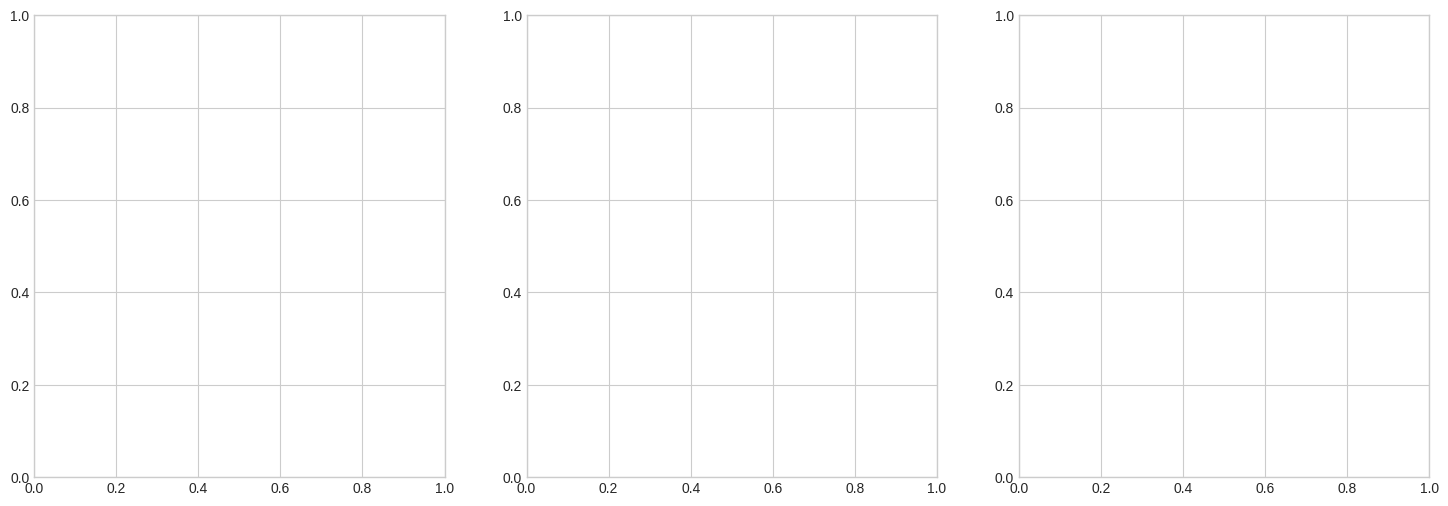

In [39]:
# 1. Model Performance Comparison
models = ['XGBoost', 'Random Forest', 'Neural Network', 'Ensemble']
mse_values = [xgb_mse, rf_mse, nn_mse, ensemble_mse]
r2_values = [xgb_r2, rf_r2, nn_r2, ensemble_r2]
mae_values = [xgb_mae, rf_mae, nn_mae, ensemble_mae]

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

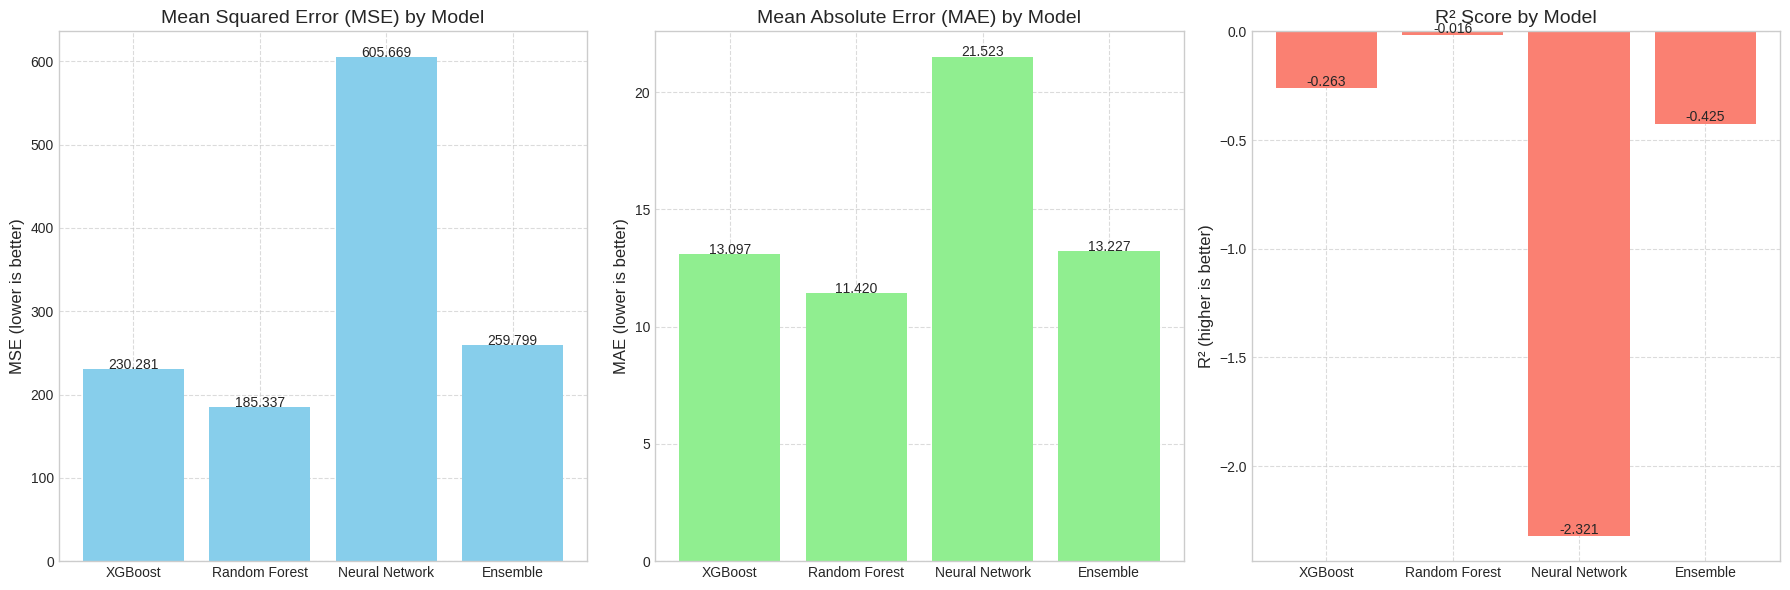

In [43]:
# For the model performance comparison visualization
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# MSE comparison
ax[0].bar(models, mse_values, color='skyblue')
ax[0].set_title('Mean Squared Error (MSE) by Model', fontsize=14)
ax[0].set_ylabel('MSE (lower is better)', fontsize=12)
for i, v in enumerate(mse_values):
    ax[0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)
ax[0].grid(True, linestyle='--', alpha=0.7)

# MAE comparison
ax[1].bar(models, mae_values, color='lightgreen')
ax[1].set_title('Mean Absolute Error (MAE) by Model', fontsize=14)
ax[1].set_ylabel('MAE (lower is better)', fontsize=12)
for i, v in enumerate(mae_values):
    ax[1].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)
ax[1].grid(True, linestyle='--', alpha=0.7)

# R² comparison
ax[2].bar(models, r2_values, color='salmon')
ax[2].set_title('R² Score by Model', fontsize=14)
ax[2].set_ylabel('R² (higher is better)', fontsize=12)
for i, v in enumerate(r2_values):
    ax[2].text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=10)
ax[2].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
# Make sure to save the figure
plt.savefig('model_performance_comparison.png', dpi=300)
# plt.show() might not work in all environments

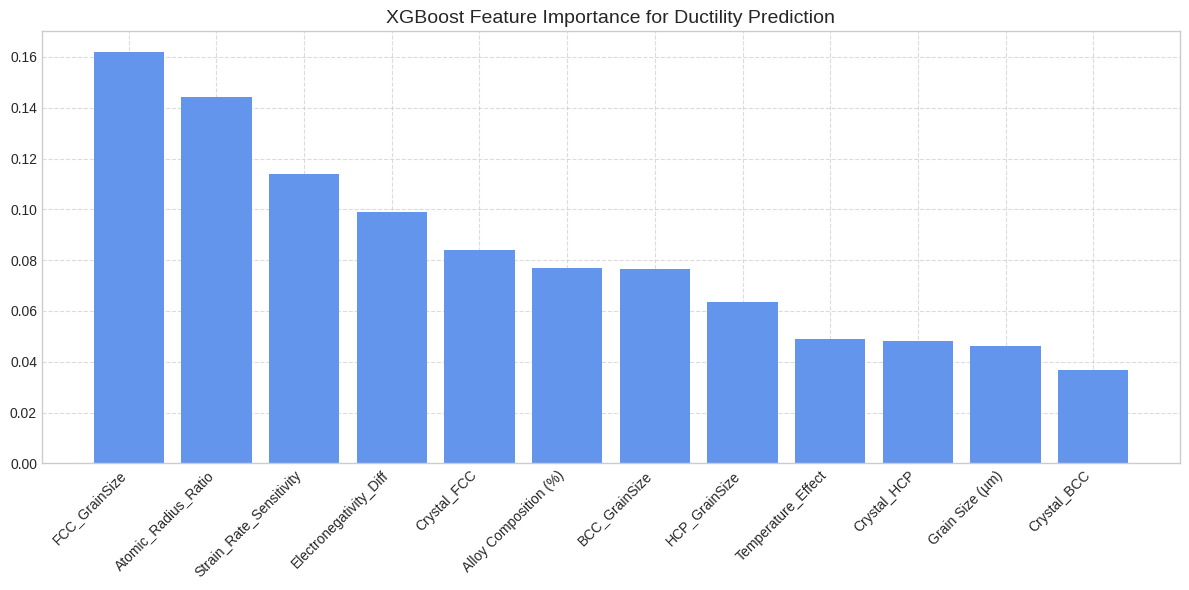

In [44]:
# 2. Feature Importance Analysis
# For XGBoost
plt.figure(figsize=(12, 6))
xgb_importance = xgb_model.feature_importances_
xgb_features = X.columns
indices = np.argsort(xgb_importance)[::-1]

plt.bar(range(len(xgb_importance)), xgb_importance[indices], color='cornflowerblue')
plt.xticks(range(len(xgb_importance)), [xgb_features[i] for i in indices], rotation=45, ha='right')
plt.title('XGBoost Feature Importance for Ductility Prediction', fontsize=14)
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('xgboost_feature_importance.png', dpi=300)
plt.show()

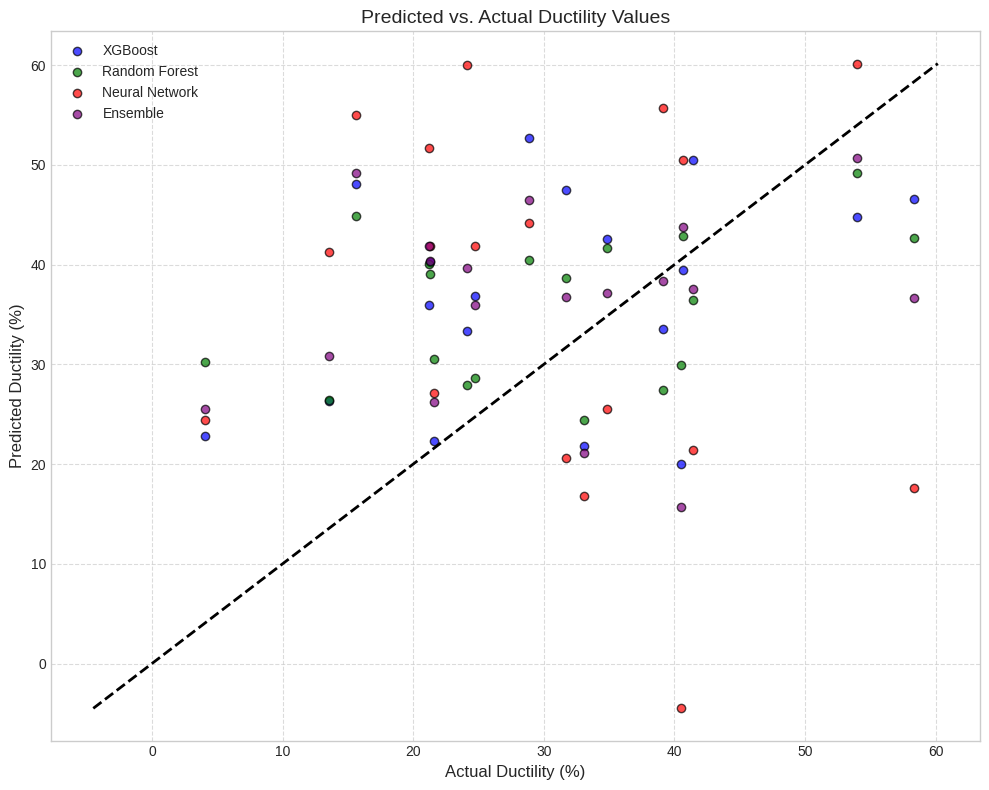

In [45]:
# 3. Predicted vs. Actual Values
plt.figure(figsize=(10, 8))
plt.scatter(y_test, xgb_pred, alpha=0.7, label='XGBoost', color='blue', edgecolor='k')
plt.scatter(y_test, rf_pred, alpha=0.7, label='Random Forest', color='green', edgecolor='k')
plt.scatter(y_test, nn_pred, alpha=0.7, label='Neural Network', color='red', edgecolor='k')
plt.scatter(y_test, ensemble_pred, alpha=0.7, label='Ensemble', color='purple', edgecolor='k')

# Add perfect prediction line
max_val = max(y_test.max(), max(xgb_pred.max(), rf_pred.max(), nn_pred.max(), ensemble_pred.max()))
min_val = min(y_test.min(), min(xgb_pred.min(), rf_pred.min(), nn_pred.min(), ensemble_pred.min()))
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)

plt.title('Predicted vs. Actual Ductility Values', fontsize=14)
plt.xlabel('Actual Ductility (%)', fontsize=12)
plt.ylabel('Predicted Ductility (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('predicted_vs_actual.png', dpi=300)
plt.show()

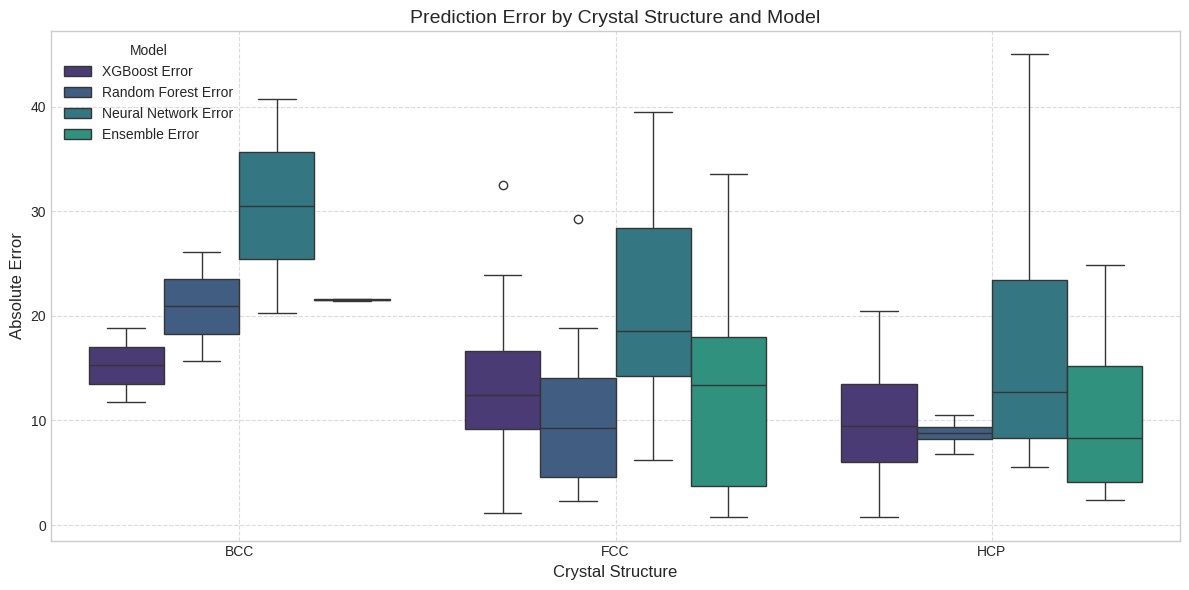

In [46]:
# 4. Error Analysis by Crystal Structure
# Extract crystal structure from original data for test set
y_test_index = y_test.index
test_crystal = data.loc[y_test_index, 'Crystal Structure']

plt.figure(figsize=(12, 6))
error_df = pd.DataFrame({
    'Crystal Structure': test_crystal,
    'XGBoost Error': abs(y_test - xgb_pred),
    'Random Forest Error': abs(y_test - rf_pred),
    'Neural Network Error': abs(y_test - nn_pred),
    'Ensemble Error': abs(y_test - ensemble_pred)
})

error_melted = pd.melt(error_df,
                       id_vars=['Crystal Structure'],
                       value_vars=['XGBoost Error', 'Random Forest Error', 'Neural Network Error', 'Ensemble Error'],
                       var_name='Model', value_name='Absolute Error')

sns.boxplot(x='Crystal Structure', y='Absolute Error', hue='Model', data=error_melted)
plt.title('Prediction Error by Crystal Structure and Model', fontsize=14)
plt.xlabel('Crystal Structure', fontsize=12)
plt.ylabel('Absolute Error', fontsize=12)
plt.legend(title='Model')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('error_by_crystal_structure.png', dpi=300)
plt.show()